In [65]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import geopandas as gpd
from matplotlib import cm
%matplotlib inline

In [42]:
df = pd.read_csv('data/opportunities.csv',low_memory=False)
df.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


In [43]:
df.Region.value_counts()

Japan          4892
EMEA           4664
Americas       3945
APAC           3262
Middle East     184
Name: Region, dtype: int64

In [44]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [45]:
#agrego singapore que no esta en el df world
singapore = gpd.read_file('Maps/Singapore_AL2-AL2.shp')
singapore = singapore.loc[:,["name","country","geometry"]]
singapore.columns = ["name","iso_a3","geometry"]
singapore["continent"] = "Asia"
singapore.head()

,name,iso_a3,geometry,continent
0,Singapore,SGP,"MULTIPOLYGON (((103.74070 1.15869, 103.74065 1...",Asia


In [46]:
df_geo = df.loc[:,["Opportunity_ID","Stage","Region","Territory","Billing_Country"]]
df_geo['Billing_Country'] = df_geo['Billing_Country'].fillna(df['Territory'])
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("United States", "United States of America")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Korea, Republic of", "South Korea")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Korea, Democratic People's Republic of", "North Korea")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Reunion", "France")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Macedonia, the former Yugoslav Republic of", "Macedonia")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Bosnia and Herzegovina", "Bosnia and Herz.")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Dominican Republic", "Dominican Rep.")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Viet Nam", "Vietnam")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Czech Republic", "Czechia")
df_geo["Territory"] = df_geo["Territory"].replace("None",np.NaN)
df_geo["Region"] = df_geo["Region"].replace("None",np.NaN)
df_geo["Billing_Country"] = df_geo["Billing_Country"].replace("None",np.NaN)
df_geo = df_geo.groupby("Billing_Country").agg({"Opportunity_ID":"count","Region":"first","Territory":"first"}).reset_index()
df_geo = df_geo.rename(columns={"Opportunity_ID":"count"})
df_geo.head()

,Billing_Country,count,Region,Territory
0,Albania,2,EMEA,Albania
1,Argentina,1,Americas,SE America
2,Armenia,2,EMEA,Armenia
3,Australia,1169,APAC,Australia
4,Austria,145,EMEA,Austria


In [47]:
def region(x):
    if x["Region"] is np.NaN:
        if x.continent == "Africa" or x.continent == "Europe":
            return "EMEA"
        elif x.continent == "Asia" or x.continent == "Oceania":
            return "APAC"
        elif x.continent == "North America" or "South America":
            return "Americas"
        return None
    return  x["Region"]

In [48]:
dfmerge = world.merge(how="left",right=df_geo,right_on="Billing_Country",left_on="name")
dfmerge["Region"] = dfmerge.apply(region, axis=1)
dfmerge["count"] = dfmerge.groupby("Region")["count"].transform("sum").fillna(0)
dfmerge.nlargest(1,"count")

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Billing_Country,count,Region,Territory
155,126451398,Asia,Japan,JPN,4932000.0,"MULTIPOLYGON (((141.88460 39.18086, 140.95949 ...",Japan,4879.0,Japan,Japan


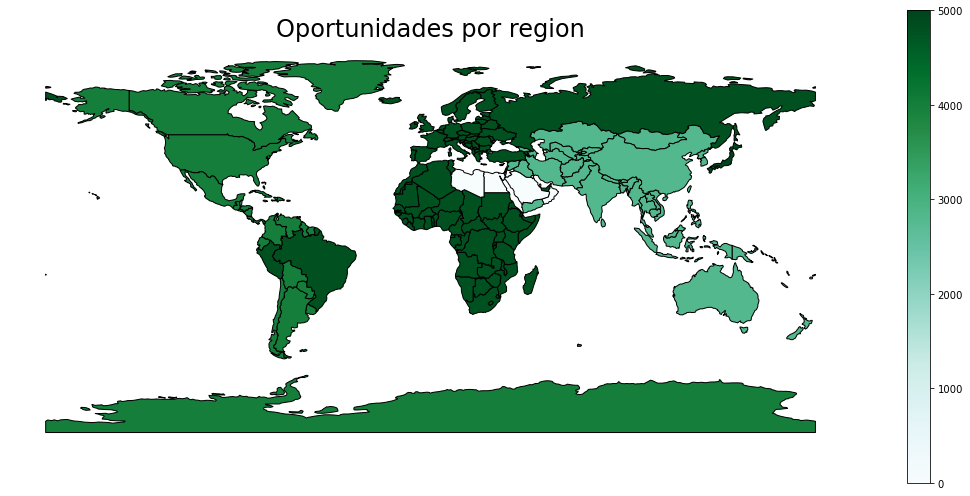

In [49]:
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.axis('off')
plt.title('Oportunidades por region',size=24)

sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=0, vmax=5000))
cbar = fig.colorbar(sm)

dfmerge.plot(column='count', cmap='BuGn', ax=ax,edgecolor='black')
plt.tight_layout()
#plt.savefig("pngs/mapa-op-region.png")

In [50]:
dfmerge_territory = world.merge(how="left",right=df_geo,right_on="Billing_Country",left_on="name")
dfmerge_territory["count"] = dfmerge_territory.groupby("Territory")["count"].transform("sum").fillna(np.NaN)
dfmerge_territory.head(1)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Billing_Country,count,Region,Territory
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN,NaN


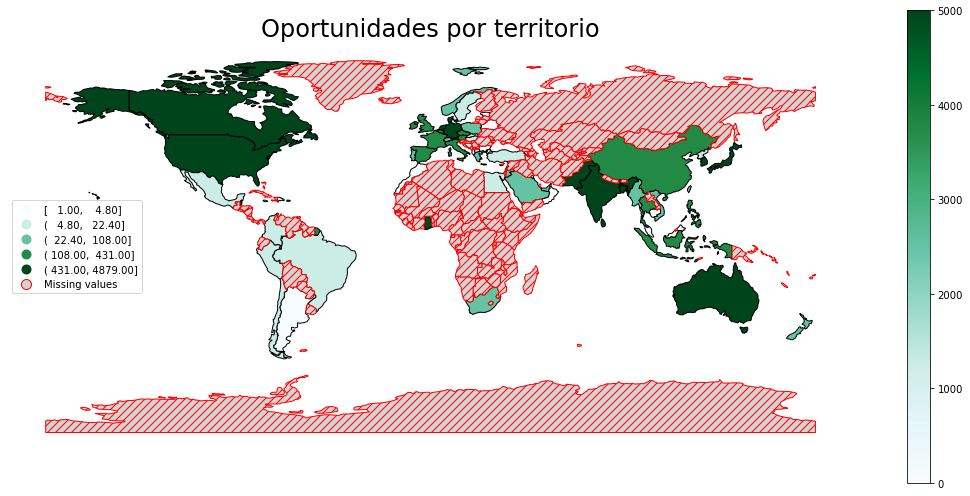

In [51]:
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.axis('off')
plt.title('Oportunidades por territorio',size=24)

sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=0, vmax=5000))
cbar = fig.colorbar(sm)

dfmerge_territory.plot(column='count', cmap='BuGn', ax=ax,edgecolor='black', 
                       scheme="quantiles",figsize=(15, 10),legend=True,
                        legend_kwds={'loc': 'center left'},
                    missing_kwds={
                         "color": "lightgrey",
                         "edgecolor": "red",
                         "hatch": "///",
                          "label": "Missing values",
      },
  )

plt.tight_layout()
#plt.savefig("pngs/mapa-op-territory.png")

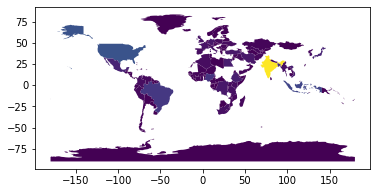

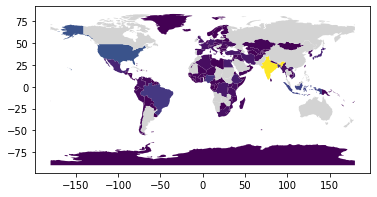

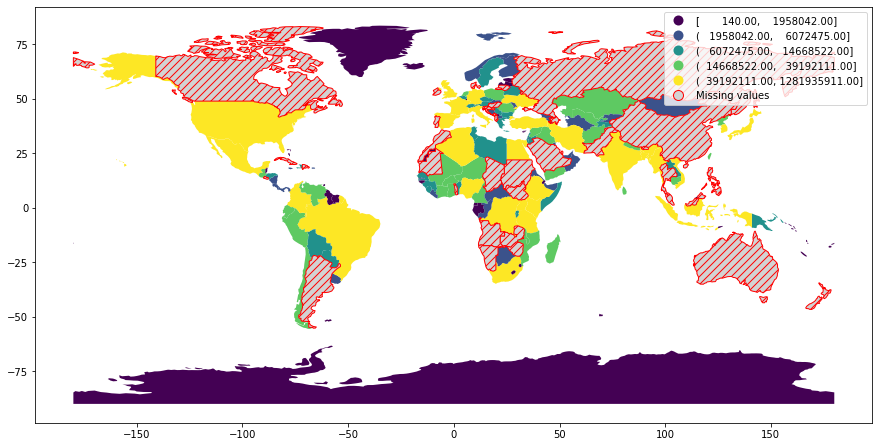

In [52]:
#Example
world.loc[np.random.choice(world.index, 40), 'pop_est'] = np.nan

world.plot(column='pop_est');
world.plot(column='pop_est', missing_kwds={'color': 'lightgrey'});

world.plot(
   column="pop_est",
legend=True,
scheme="quantiles",
figsize=(15, 10),
 missing_kwds={
           "color": "lightgrey",
           "edgecolor": "red",
         "hatch": "///",
           "label": "Missing values",
       },
   );